In [99]:
import torch
import pymilvus

import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Subset
from transformers import AutoImageProcessor, AutoModel, AutoModelForImageClassification
from torchvision.datasets import DatasetFolder, ImageFolder
from torchvision import transforms
from datasets import load_dataset

from torch.utils.data import DataLoader
from tqdm import tqdm

In [102]:
transformers = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
])

In [103]:
class ImageFolderWithPaths(ImageFolder):
    """Custom dataset that includes image file paths. Extends
    torchvision.datasets.ImageFolder
    """

    # override the __getitem__ method. this is the method that dataloader calls
    def __getitem__(self, index):
        # this is what ImageFolder normally returns 
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # the image file path
        path = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [104]:
dataset = ImageFolderWithPaths("/home/thmtt/Downloads/train", transform=transformers)

In [119]:
subset = Subset(dataset, [i for i in range(500)] + [i for i in range(len(dataset) - 1, len(dataset) - 501, -1)])

In [120]:
dataloader = DataLoader(subset, batch_size=32)

In [121]:
model_ckpt = "./super_giga_model"
processor = AutoImageProcessor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)   
# clf = AutoModelForImageClassification.from_pretrained(model_ckpt, num_labels=2)

Some weights of ViTModel were not initialized from the model checkpoint at ./super_giga_model and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [122]:
def extract_embeddings(processor: torch.nn.Module, model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch
        # images = batch["image"]
        # images = processor(batch)["image"]
        # `transformation_chain` is a compostion of preprocessing
        # transformations we apply to the input images to prepare them
        # for the model. For more details, check out the accompanying Colab Notebook.
        # image_batch_transformed = torch.stack(
        #     [transformation_chain(image) for image in images]
        # )
        # images = batch["image"]
        # print(type(images))
        new_batch = {"pixel_values": images.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return embeddings

    return pp

In [123]:
from pymilvus import Collection, connections, DataType, CollectionSchema, FieldSchema, DataType

In [124]:
connections.connect(host='localhost', port=19530)

In [125]:
pymilvus.utility.drop_collection("kicie_i_pieski")

In [126]:
animal_id = FieldSchema(
    name="animal_id",
    dtype=DataType.INT64,
    is_primary=True
)
animal_type = FieldSchema(
    name="animal_type",
    dtype=DataType.VARCHAR,
    max_length=64
)
animal_name = FieldSchema(
    name="animal_name",
    dtype=DataType.VARCHAR,
    max_length=64
)
animal_vector = FieldSchema(
    name="animal_vector",
    dtype=DataType.FLOAT_VECTOR,
    dim=768,
)

schema = CollectionSchema(
    fields=[animal_id, animal_type, animal_name, animal_vector],
    descripton="Animal database",
)

In [127]:
collection = Collection(name="kicie_i_pieski", schema=schema)

In [128]:
index_params = {
    'metric_type': 'L2',
    'index_type': 'FLAT',
    'params': {
        'nlist': 1024
    }
}

In [129]:
collection.create_index(
    field_name="animal_vector",
    index_params=index_params
)

Status(code=0, message=)

In [130]:
pymilvus.utility.index_building_progress("kicie_i_pieski")

{'total_rows': 0, 'indexed_rows': 0, 'pending_index_rows': 0}

In [131]:
embedder = extract_embeddings(processor, model.to('cuda:0'))

In [132]:
for idx, (input, labels, path) in enumerate(tqdm(dataloader)):
    input = input.to('cuda:0')
    embedding = embedder(input)
    values = embedding
    batch_size = values.shape[0]
    data = [
        [idx * batch_size + i for i in range(batch_size)],
        [str(labels[i]) for i in range(batch_size)],
        [path[i] for i in range(batch_size)],
        [values[i, :].tolist() for i in range(batch_size)]
    ]
    collection.insert(data)
    # if idx > 100:
    #     break

100%|██████████| 32/32 [00:18<00:00,  1.68it/s]


In [133]:
collection.flush()

In [134]:
collection.num_entities

1000

In [135]:
from PIL import Image

In [136]:
galgan_1 = transformers(Image.open('/home/thmtt/Downloads/galgan_1.jpg'))

In [137]:
galgan_1.shape

torch.Size([3, 224, 224])

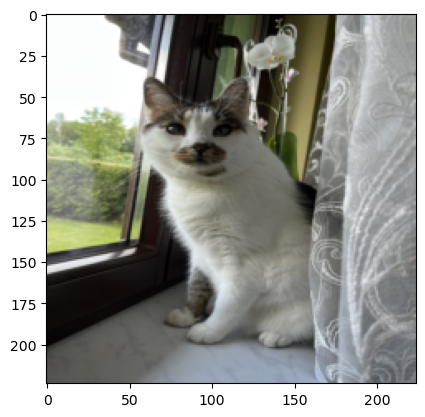

In [138]:
plt.imshow(galgan_1.permute(1, 2, 0))

In [139]:
embed = embedder(galgan_1.unsqueeze(0))

In [140]:
collection.insert([
    [999999],
    ['kot'],
    ['galgan'],
    [embed[0].tolist()]
])
collection.flush()

In [141]:
embedding.shape

torch.Size([8, 768])

In [142]:
galgan_2 = transformers(Image.open('/home/thmtt/Downloads/galgan_2.JPG'))

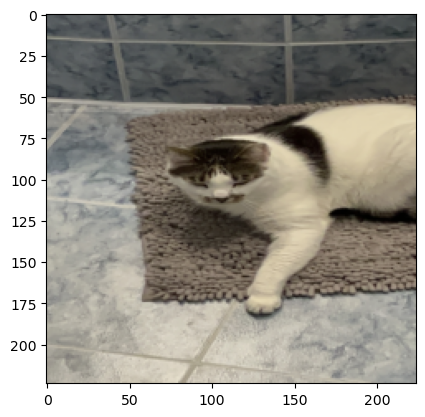

In [143]:
plt.imshow(galgan_2.permute(1, 2, 0))

In [144]:
embed = embedder(galgan_2.unsqueeze(0))

In [145]:
collection.load()

In [146]:
res = collection.search(
    data=[embed[0].tolist()],
    anns_field='animal_vector',
    param={
        'metric_type': 'L2',
    },
    output_fields=['animal_id', 'animal_type', 'animal_name'],
    limit=5
)

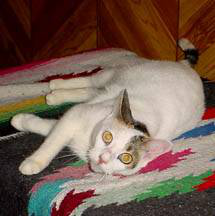

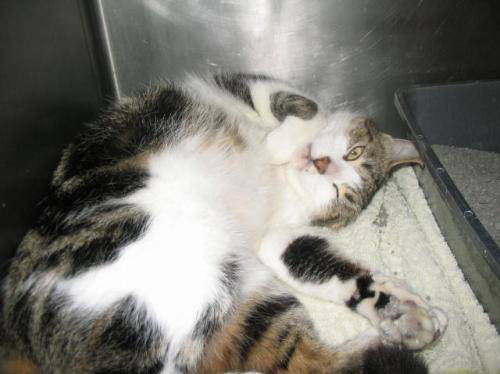

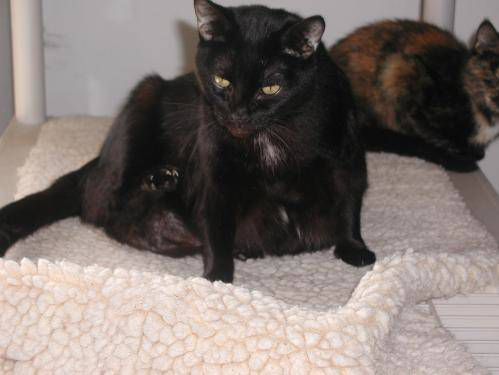

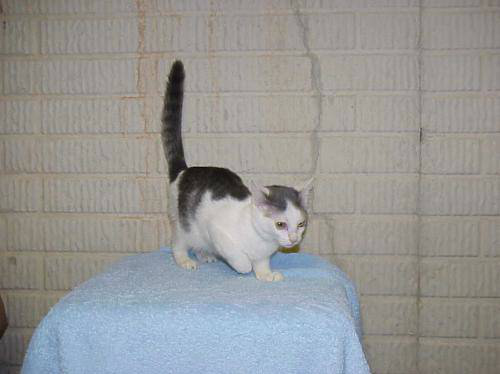

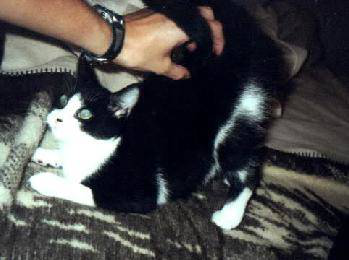

In [147]:
for img in [x.entity.get("animal_name") for x in res[0]]:
    display(Image.open(img))

In [148]:
import os

In [155]:
kot = "kicia"
kot_id = 40000

paths = [f"/home/thmtt/Downloads/{kot}/{path}" for path in os.listdir(f"/home/thmtt/Downloads/{kot}")]

kicia_tensor = torch.stack([
  transformers(Image.open(p))
               for p in paths
])

In [156]:
embedding = embedder(kicia_tensor)

In [157]:
batch_size = kicia_tensor.shape[0]

collection.insert([
    [kot_id + i for i in range(batch_size)],
    ['cat' for i in range(batch_size)],
    [paths[i] for i in range(batch_size)],
    [embedding[i].tolist() for i in range(batch_size)]]
)
collection.flush()

In [39]:
collection.delete(f'animal_id in [{",".join([str(i) for i in range(30000, 30006)] + [str(i) for i in range(50000, 500006)])}]')

(insert count: 0, delete count: 450012, upsert count: 0, timestamp: 444623561731866627, success count: 0, err count: 0)

In [158]:
def find_cat(path, n=5):
    img = transformers(Image.open(path))
    embed = embedder(img.unsqueeze(0))
    res = collection.search(
    data=[embed[0].tolist()],
    anns_field='animal_vector',
    param={
        'metric_type': 'L2',
    },
    output_fields=['animal_id', 'animal_type', 'animal_name'],
    limit=n
    )
    return [x.entity.get("animal_name") for x in res[0] if x.entity.get("animal_name") != path]

In [159]:
collection.num_entities

1022

In [160]:
import PIL

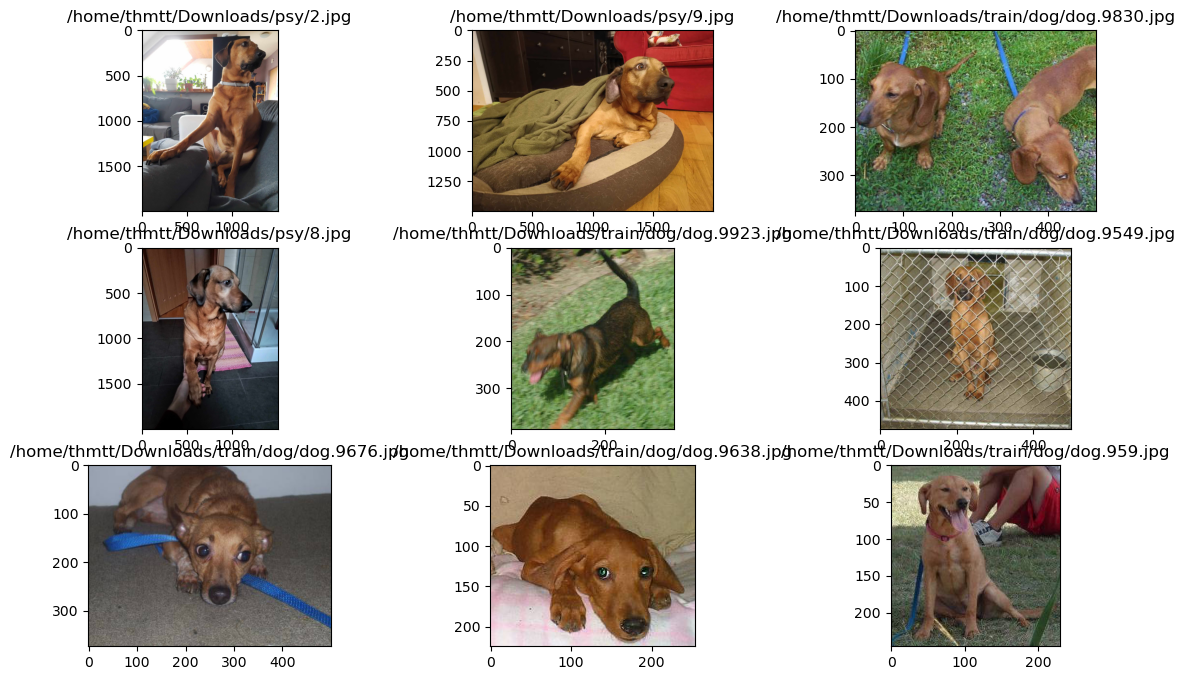

In [173]:
paths = find_cat('/home/thmtt/Downloads/psy/5.jpg', n=10)
fig, ax = plt.subplots(3, 3)
ax = ax.flatten()
for i, path in enumerate(paths):
    ax[i].imshow(np.array(Image.open(path)))
    ax[i].set_title(path)
    Image.open(path).save(f'/home/thmtt/Downloads/kandydaci/{i}.jpg')
fig.set_size_inches(14, 8)

In [90]:
embedding[0].tolist() 

KeyError: 0

In [47]:
dataset[3605]

(tensor([[[-1.6727, -1.6727, -1.6213,  ...,  0.4679,  0.4166,  0.3138],
          [-1.6555, -1.6384, -1.6213,  ...,  0.4851,  0.3994,  0.2453],
          [-1.6727, -1.6213, -1.6555,  ...,  0.3823,  0.1939,  0.0569],
          ...,
          [-0.5424, -0.4739, -0.4226,  ..., -0.3541, -0.5596, -0.6965],
          [-0.5596, -0.4739, -0.5253,  ...,  0.1083,  0.0569, -0.0458],
          [-0.4568, -0.4226, -0.5596,  ...,  0.3309,  0.3309,  0.2111]],
 
         [[-1.5455, -1.5455, -1.4930,  ...,  0.6779,  0.6078,  0.4503],
          [-1.5280, -1.5105, -1.4930,  ...,  0.6954,  0.5728,  0.3803],
          [-1.5455, -1.4930, -1.5280,  ...,  0.5553,  0.3452,  0.1877],
          ...,
          [-0.5476, -0.4776, -0.4251,  ..., -0.8452, -1.0378, -1.0903],
          [-0.5651, -0.4776, -0.5301,  ..., -0.6001, -0.6352, -0.6702],
          [-0.4601, -0.4251, -0.5651,  ..., -0.5301, -0.5126, -0.5826]],
 
         [[-1.3339, -1.3339, -1.2816,  ...,  0.8797,  0.8099,  0.6705],
          [-1.3164, -1.2990,